# Projet 4 : Segmentez des clients d’un site e-commerce
##### Parcours: Ingénieur Machine Learning from OpenClassrooms
##### Ana Ibarra Velázquez

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import plotly.graph_objects as go
import operator
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Fonctions for plotting

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None,\
                    label_rotation=0, lims=None):
    # On affiche les premiers plans factoriels
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:
            fig, ax = plt.subplots(figsize=(7,6))
            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]),\
                                         min(pcs[d2,:]), max(pcs[d2,:])
            # affichage des flèches           
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")           
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center',\
                                 va='center', rotation=label_rotation,\
                                 color="blue", alpha=0.5)            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*\
                                   pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*\
                                   pca.explained_variance_ratio_[d2],1)))
            plt.title("Circle of correlations (F{} et F{})".format(d1+1,d2+1))
            plt.show(block=False)
        
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rank of the axis of inertia")
    plt.ylabel("percentage of inertia")
    plt.title("Eigenvalues")
    plt.show(block=False)

def plot_sample_silhouette(X, n_clusters, cluster_labels,\
                           silhouette_avg, clusterer):
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 7)
    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]        
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 
        
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")    
    # Vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering"
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()    
    
def plot_scatterpolar(median_cluster,categories):
    # Polar graph of targets for each cluster
    print(median_cluster)
    fig = go.Figure()
    for cl in range(len(median_cluster)):
        fig.add_trace(go.Scatterpolar(r=median_cluster.iloc[cl,:],
                      theta=categories,fill='toself', name='Cluster'+str(cl)))
    fig.update_layout(polar=dict(radialaxis=dict(visible=True,
              range=[0,8])), showlegend=True)    
    fig.show()

In [3]:
# Chargement de dataset CSV
data_SG = pd.read_csv('Segmentation-clients-2ML.csv', sep='\t')

In [4]:
data_SG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114962 entries, 0 to 114961
Data columns (total 9 columns):
customer_id                      114962 non-null object
customer_unique_id               114962 non-null object
customer_state                   114962 non-null object
order_purchase_timestamp         114962 non-null object
product_category_name_english    114962 non-null object
payment_value                    114962 non-null float64
Hour                             114962 non-null int64
Date_order                       114962 non-null object
Month_order                      114962 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 7.9+ MB


### Features Engineering

In [5]:
data = data_SG

#### - Datetime features

In [6]:
# Creating variable average hour of purchcase per client
data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp)
data_hour = data.groupby('customer_unique_id').Hour.median().reset_index()
data_hour.columns = ['customer_unique_id','Hour_median']
data_hour = round(data_hour,0)
data = pd.merge(data, data_hour, on='customer_unique_id')
data = data.astype({"Hour_median":'category'}) 

#### - Product categories features

In [7]:
freq_prod = data.groupby("product_category_name_english").size()/len(data)
data.loc[:,'Product'] = data["product_category_name_english"].map(freq_prod)
data.Product.describe()
data = data.astype({"Product":'category'}) 

In [8]:
def total_products(data):
    # Total number of products a client has bought
    if 'Total_products' in data.columns:
        data.drop('Total_products', axis=1, inplace=True)
    tot_prod = data.groupby('customer_unique_id'
               ).Date_order.count().reset_index()
    tot_prod.columns = ['customer_unique_id','Total_products']
    data = pd.merge(data, tot_prod, on='customer_unique_id')
    # Categorizing clients of Total_products over 7
    data.loc[data['Total_products'] >= 7,'Total_products'] = 7
    return data

In [9]:
data = total_products(data)

#### - Payment features

In [10]:
# RECENCY : number of days that have passed since the most 
# recent purchase date for each customer

def recency_customer(data):
    if 'Recency' in data.columns:
        data.drop('Recency', axis=1, inplace=True)
    data_recency = data.groupby('customer_unique_id').\
                   order_purchase_timestamp.max().reset_index()
    # The check-point is the last purchase date in the full dataset
    data_recency['Recency'] = ((data_recency['order_purchase_timestamp'].\
            max() - data_recency['order_purchase_timestamp']).dt.days)*(-1)
    data = pd.merge(data, data_recency[['customer_unique_id','Recency']], 
                on='customer_unique_id')
    data['Recency'] = data['Recency']/(365/12)
    return data

In [11]:
data = recency_customer(data)

In [12]:
# FREQUENCY : total number of orders for each customer

def frequency_customer(data):
    if 'Frequency' in data.columns:
        print("Deleted F")
        data.drop('Frequency', axis=1, inplace=True)
    Frequency = pd.DataFrame(data.groupby('customer_unique_id')['customer_id'\
                ].nunique()).reset_index()
    Frequency.columns = ['customer_unique_id','Frequency']
    data = pd.merge(data, Frequency, on='customer_unique_id')
    # Grouping all clients of frequency over 4
    data.loc[data['Frequency']>=4,'Frequency'] = 4
    return data

In [13]:
data = frequency_customer(data)

In [14]:
# AVERAGE EXPENSE: the average quantity each customer pays 

def average_expense(data):
    if 'Avg_expense' in data.columns:
        data.drop('Avg_expense', axis=1, inplace=True)
    data_monetary = data.groupby('customer_unique_id').payment_value.sum().\
                    reset_index()
    data_monetary.columns = ['customer_unique_id','Monetary']
    data = pd.merge(data, data_monetary, on='customer_unique_id')
    data['Avg_expense'] = data['Monetary'] / data['Frequency']
    data.Avg_expense = np.log(data.Avg_expense+1)
    return data

In [15]:
data = average_expense(data)

#### - Demographie features

In [16]:
def state_encod(data):
    if 'State_encoded' in data.columns:
        data.drop('State_encoded', axis=1, inplace=True)
    freq_state = data.groupby("customer_state").size()/len(data)
    data.loc[:,'State_encoded'] = data["customer_state"].map(freq_state)
    data = data.astype({"State_encoded":'category'}) 
    return data

In [17]:
data = state_encod(data)

### Complet dataset

In [18]:
data.columns

Index(['customer_id', 'customer_unique_id', 'customer_state',
       'order_purchase_timestamp', 'product_category_name_english',
       'payment_value', 'Hour', 'Date_order', 'Month_order', 'Hour_median',
       'Product', 'Total_products', 'Recency', 'Frequency', 'Monetary',
       'Avg_expense', 'State_encoded'],
      dtype='object')

In [19]:
# Date of transactions between september 2016 - september 2018
data.order_purchase_timestamp.agg(['min', 'max'])

min   2016-09-04 21:15:19
max   2018-09-03 09:06:57
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [20]:
# Selecting columns to use in clustering
data = data[['customer_unique_id','Recency','Frequency','Avg_expense',
             'Total_products','State_encoded','Date_order']]

In [21]:
# Drop duplicates
data = data.drop_duplicates(subset=['customer_unique_id'], keep='last')
data.shape

(93670, 7)

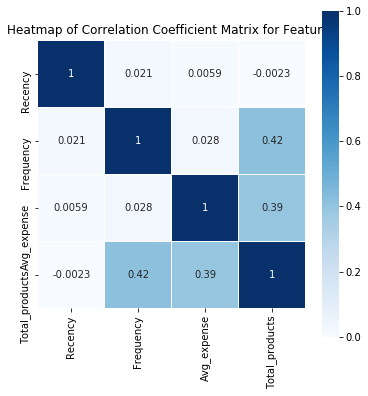

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(data.corr(),vmax=1,linewidths=0.01,square=True,annot=True,
            linecolor="white",cmap='Blues')
bottom,top = ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
heatmap_title = 'Heatmap of Correlation Coefficient Matrix for Features'
ax.set_title(heatmap_title)
plt.show()

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93670 entries, 0 to 114961
Data columns (total 7 columns):
customer_unique_id    93670 non-null object
Recency               93670 non-null float64
Frequency             93670 non-null int64
Avg_expense           93670 non-null float64
Total_products        93670 non-null int64
State_encoded         93670 non-null category
Date_order            93670 non-null object
dtypes: category(1), float64(2), int64(2), object(2)
memory usage: 5.1+ MB


### Scaling

In [24]:
ids = data.customer_unique_id
data_to_scale = data.drop(['customer_unique_id','Date_order'],axis=1)

In [25]:
data_to_scale.describe()

,Recency,Frequency,Avg_expense,Total_products
count,93670.000000,93670.000000,93670.000000,93670.000000
mean,-7.948586,1.033095,4.791466,1.219921
std,5.030670,0.197168,0.897136,0.652103
min,-23.934247,1.000000,2.288486,1.000000
25%,-11.539726,1.000000,4.160756,1.000000
50%,-7.298630,1.000000,4.712768,1.000000
75%,-3.879452,1.000000,5.284966,1.000000
max,0.000000,4.000000,11.601976,7.000000


In [26]:
X = preprocessing.StandardScaler().fit_transform(data_to_scale)

In [27]:
## Tweaking the weights

# def weights_up(X):
#     weight_up = 1.2
#     X[:,1] = X[:,0]*(weight_up) # Recency
#     X[:,1] = X[:,1]*(weight_up) # Frequency
#     X[:,1] = X[:,2]*(weight_up) # Average expense
#     weight_down = 0.8
#     X[:,1] = X[:,0]*(weight_down) # State encoded
#     X[:,1] = X[:,4]*(weight_down) # Hour median
#     return X

In [28]:
# X = weights_up(X)

### PCA

In [29]:
features = data_to_scale.columns
n_comp = 4

In [30]:
# PCA
def PCA_features(X, n_comp):
    pca = decomposition.PCA(n_components = n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca, pca

In [31]:
X_pca, pca = PCA_features(X, n_comp)

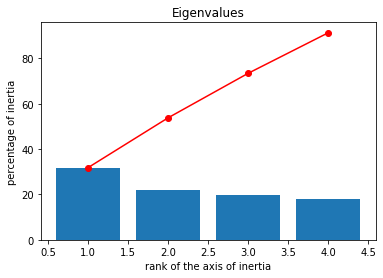

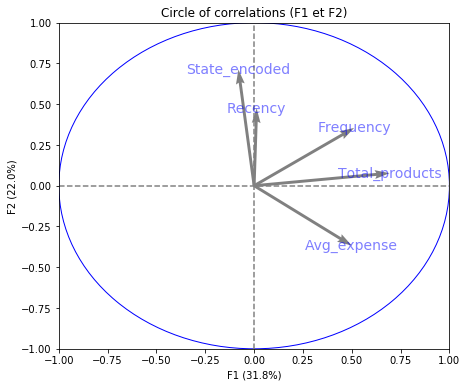

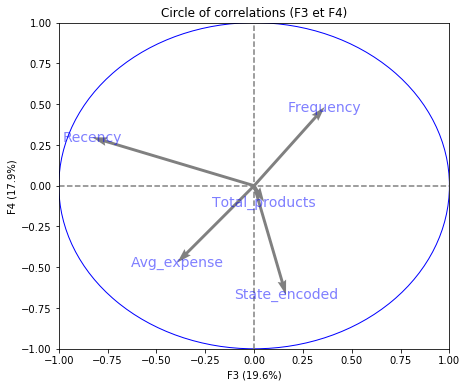

In [32]:
# Eigenvalues
# print (pca.explained_variance_ratio_.cumsum())
display_scree_plot(pca)

# Correlation circle 
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(features))
plt.show()

### Selection of number of clusters by k-means

A range of number of clusters is defined by the user and modeled by k-means clustering. 
By means of visual analysis and the silhouette score, the best number of clusters 
will be found.

In [33]:
def cluster_kmeans(X,n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', 
                       max_iter=600, random_state=1)
    kmeans_label = clusterer.fit_predict(X)

    # The silhouette_score 
    silhouette_avg = silhouette_score(X, kmeans_label)
    print("For n_clusters =",n_clusters,", The average silhouette_score is :", 
               round(silhouette_avg*100,1),'%')
    return kmeans_label, silhouette_avg, clusterer 

k-Means Clustering: 
For n_clusters = 3 , The average silhouette_score is : 35.0 %
[0.350184360284438]


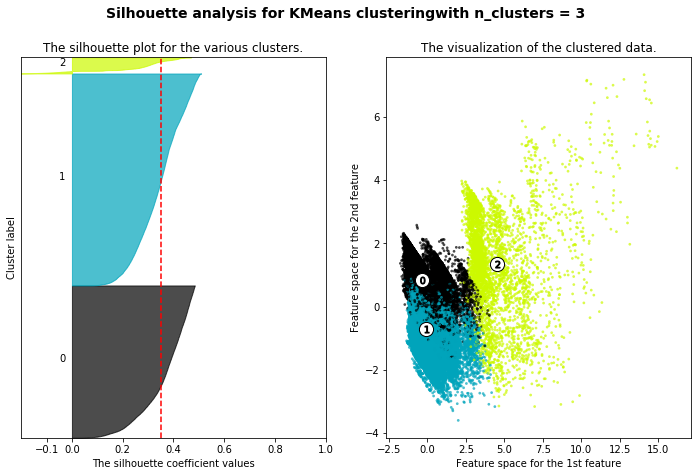

k-Means Clustering: 
For n_clusters = 4 , The average silhouette_score is : 36.4 %
[0.350184360284438, 0.3644236671292675]


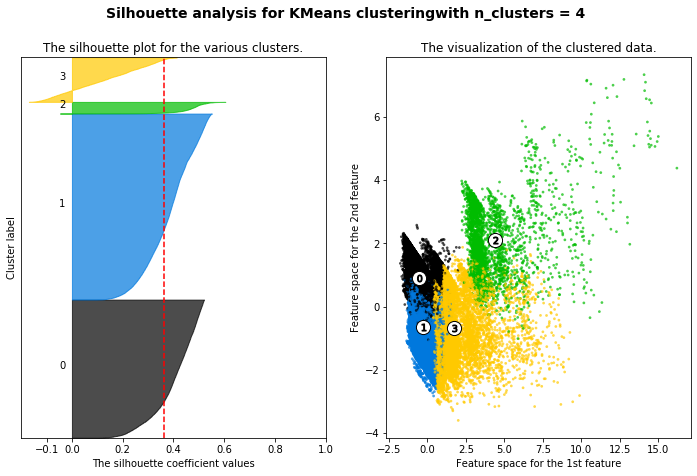

k-Means Clustering: 
For n_clusters = 5 , The average silhouette_score is : 35.3 %
[0.350184360284438, 0.3644236671292675, 0.35278442116776526]


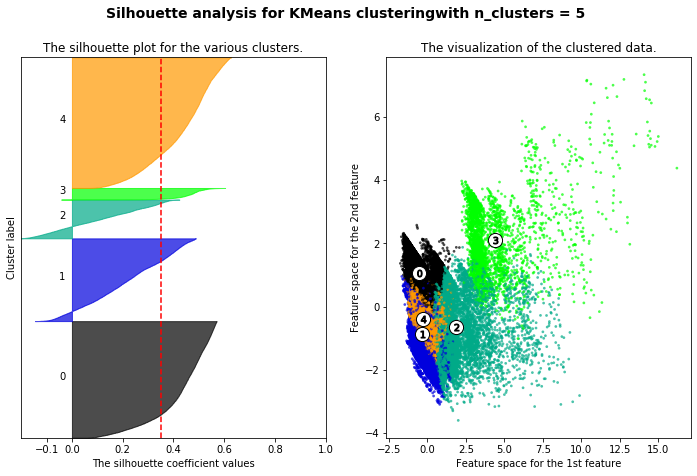

k-Means Clustering: 
For n_clusters = 6 , The average silhouette_score is : 34.8 %
[0.350184360284438, 0.3644236671292675, 0.35278442116776526, 0.34843125975702005]


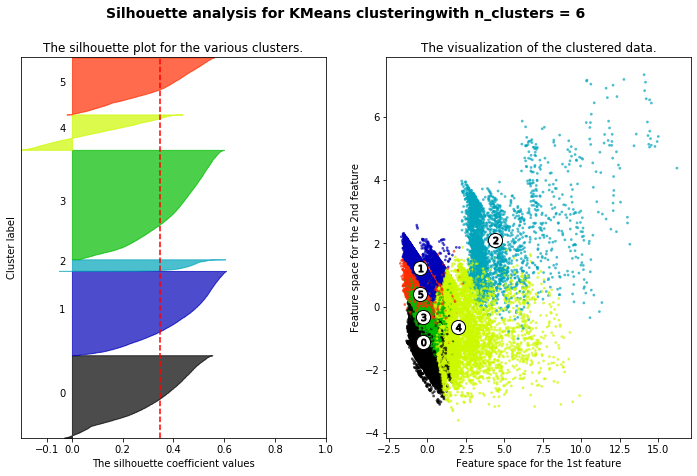

k-Means Clustering: 
For n_clusters = 7 , The average silhouette_score is : 35.2 %
[0.350184360284438, 0.3644236671292675, 0.35278442116776526, 0.34843125975702005, 0.3524961385104411]


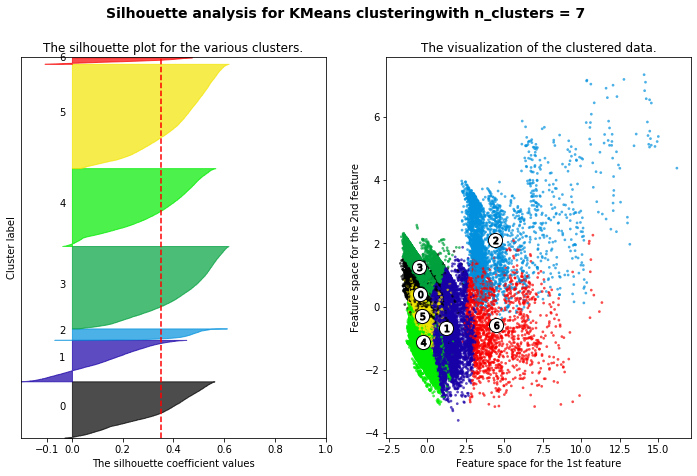

k-Means Clustering: 
For n_clusters = 8 , The average silhouette_score is : 35.6 %
[0.350184360284438, 0.3644236671292675, 0.35278442116776526, 0.34843125975702005, 0.3524961385104411, 0.3559939841367837]


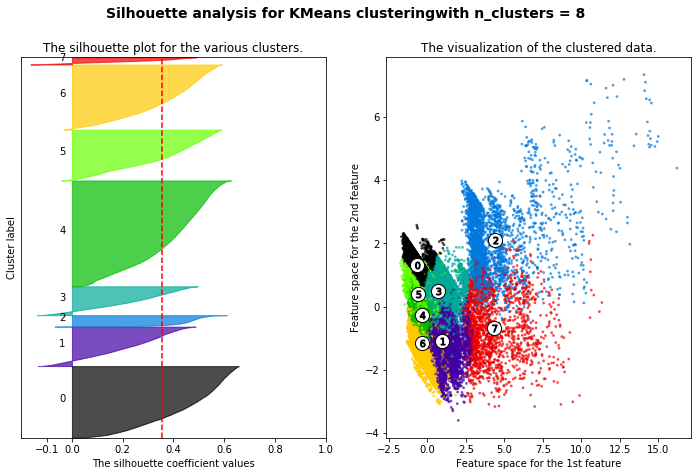

k-Means Clustering: 
For n_clusters = 9 , The average silhouette_score is : 35.7 %
[0.350184360284438, 0.3644236671292675, 0.35278442116776526, 0.34843125975702005, 0.3524961385104411, 0.3559939841367837, 0.35722907939313686]


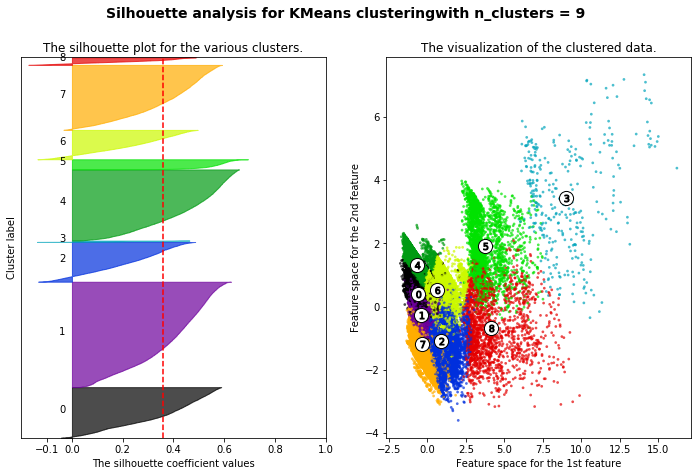

In [34]:
# Clustering
range_n_clusters = [3,4,5,6,7,8,9]
kmeans_silhouette = []
kmeans_labels = []
for n_clusters in range_n_clusters:   
    kmeans_label, silhouette_avg, clusterer = cluster_kmeans(X_pca,n_clusters)
    kmeans_silhouette.append(silhouette_avg)
    kmeans_labels.append(kmeans_label)
    plot_sample_silhouette(X_pca, n_clusters, kmeans_label,\
                           silhouette_avg, clusterer)

In [35]:
max_sil_index = kmeans_silhouette.index(max(kmeans_silhouette))
n_clusters = range_n_clusters[max_sil_index]
print ("Taking into account the silhouette score for three or more clusters,\n" 
       "the ideal number of clusters for all the data in this project is: ", 
       n_clusters)

Taking into account the silhouette score for three or more clusters,
the ideal number of clusters for this project is:  4


### Unsupervised clustering models 

After choosing the best number of clusters, the performance of three clustering
models: 
k-means, agglomerative and DBSCAN will be compared by the silhouette score.

#### k-means clustering

In [38]:
n_clusters =4

In [39]:
kmeans_label,silhouette_avg,clusterer = cluster_kmeans(X_pca, n_clusters)

For n_clusters = 4 , The average silhouette_score is : 36.4 %


In [40]:
# Create the label column 
if "label" in data_to_scale.columns:
    data_to_scale.drop("label", axis=1, inplace=True)
data_to_scale.insert(5, "label", kmeans_label, True)
# Count the number of customers for each cluster
median_kmeans_cluster = []
for n in range(n_clusters):    
    actual_cluster = data_to_scale[data_to_scale.label == n]
    median_kmeans_cluster.append(np.median(actual_cluster,0))
    print("In cluster",n,": ",len(actual_cluster)," customers")
median_kmeans_cluster = pd.DataFrame(median_kmeans_cluster,\
                columns=data_to_scale.columns,index=range(n_clusters))

In cluster 0 :  34030  customers
In cluster 1 :  45808  customers
In cluster 2 :  2862  customers
In cluster 3 :  10970  customers


#### DBSCAN clustering

In [41]:
def cluster_DBSCAN(X_pca):
    # Compute DBSCAN
    db = DBSCAN(eps=0.5, min_samples=200).fit(X_pca)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    dbscan_labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise_ = list(dbscan_labels).count(-1)

    # The silhouette_score value
    silhouette_avg = silhouette_score(X_pca, dbscan_labels)
    #print('Estimated number of noise points: %d' % n_noise_)
    print("DBSCAN Clustering:\n"
          'Estimated number of clusters: %d' % n_clusters_,
          "The average silhouette_score is :", 
          round(silhouette_avg*100,1),'%')
    return dbscan_labels, silhouette_avg, db, n_clusters_ 

In [42]:
dbscan_label,silhouette_avg,clusterer,n_clusters_db = cluster_DBSCAN(X_pca)

DBSCAN Clustering:
Estimated number of clusters: 4 The average silhouette_score is : 24.3 %


In [43]:
# Create label column and count number of customers
if "label_dbscan" in data_to_scale.columns:
    data_to_scale.drop("label_dbscan",axis=1,inplace=True)
data_to_scale.insert(6, "label_dbscan", dbscan_label, True)
median_db_cluster = []
for n in range(n_clusters_db):    
    actual_cluster = data_to_scale[data_to_scale.label_dbscan == n]
    median_db_cluster.append(np.median(actual_cluster,0))
    print("In cluster",n,": ",len(actual_cluster)," customers")
median_db_cluster = pd.DataFrame(median_db_cluster,\
                    columns=data_to_scale.columns,index=range(n_clusters))
data_to_scale.drop("label_dbscan",axis=1,inplace=True)

In cluster 0 :  33064  customers
In cluster 1 :  45931  customers
In cluster 2 :  4037  customers
In cluster 3 :  3066  customers


#### Aglomerative clustering

Only a sample of data sed is used in this model, due to memory restrictions

In [44]:
def cluster_agglomerative(X_pca, n_clusters):
    # Agglomerative Clustering for a sample of 50k entries
    len_limit = 50000
    if len(X_pca) > len_limit:
        X_pca_sample = X_pca[:len_limit,:]
    else:
        X_pca_sample = X_pca
    agglom = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
    agglom.fit(X_pca_sample)
    agglom_labels = agglom.labels_
    silhouette_avg = silhouette_score(X_pca_sample, agglom_labels)
    print("Agglomerative Clustering:\n"
          "For n_clusters =", n_clusters,
          ", The average silhouette_score is :", 
          round(silhouette_avg*100,1),'%')
    return agglom_labels, silhouette_avg, agglom 

In [ ]:
len_limit = 50000
data_agglom = data_to_scale.iloc[:len_limit,:]
agglom_label,silhouette_avg,clusterer = cluster_agglomerative(\
                                X_pca[:len_limit,:],n_clusters)

In [ ]:
# Create label column and count number of customers
if "label_agglom" in data_agglom.columns:
    data_agglom.drop("label_agglom", axis=1, inplace=True)
data_agglom.insert(6, "label_agglom", agglom_label, True) 
median_agglom_cluster = []
for n in range(n_clusters):    
    actual_cluster = data_agglom[\
                    data_agglom.label_agglom == n]
    median_agglom_cluster.append(np.median(actual_cluster,0))
    print("In cluster",n,": ",len(actual_cluster)," customers")
median_agglom_cluster = pd.DataFrame(median_agglom_cluster,\
            columns=data_agglom.columns,index=range(n_clusters))

In [ ]:
# Features traitement for better visualisation
if np.median(median_kmeans_cluster.Recency) < 0:
    median_kmeans_cluster.Recency = -median_kmeans_cluster.Recency
    median_db_cluster.Recency = -median_db_cluster.Recency
    median_agglom_cluster.Recency = -median_agglom_cluster.Recency
if np.median(median_kmeans_cluster.State_encoded) < 1:
    median_kmeans_cluster.State_encoded = np.array(\
                                    median_kmeans_cluster.State_encoded)*10
    median_db_cluster.State_encoded = np.array(\
                                    median_db_cluster.State_encoded)*10
    median_agglom_cluster.State_encoded = np.array(\
                                    median_agglom_cluster.State_encoded)*10

In [ ]:
# Comparing clustering models
categories = data_to_scale.columns[:-1]
print("k-means clustering")
plot_scatterpolar(median_kmeans_cluster.loc[:,categories],categories)
print("DBSAN clustering")
plot_scatterpolar(median_db_cluster.loc[:,categories],categories)
print("Agglomerative clustering")
plot_scatterpolar(median_agglom_cluster.loc[:,categories],categories)

#### Cluster Description 
To analyse the customer clustering, the k-means model's label is used.

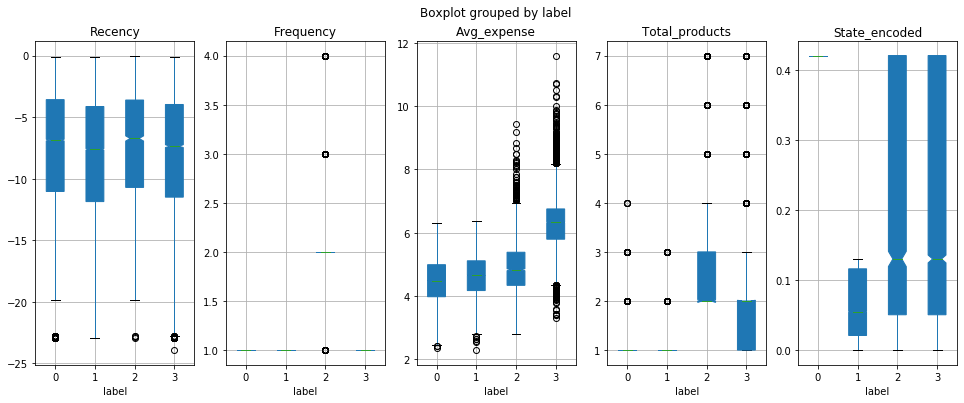

In [52]:
# Boxplot of features by label
fig, axes = plt.subplots(nrows= 1,ncols=5, figsize=(16, 6))
data_to_scale.boxplot(column=['Recency','Frequency','Avg_expense',
            'Total_products','State_encoded'], 
             by='label', notch=True, patch_artist=True,
             vert=True, ax=axes)
plt.show()

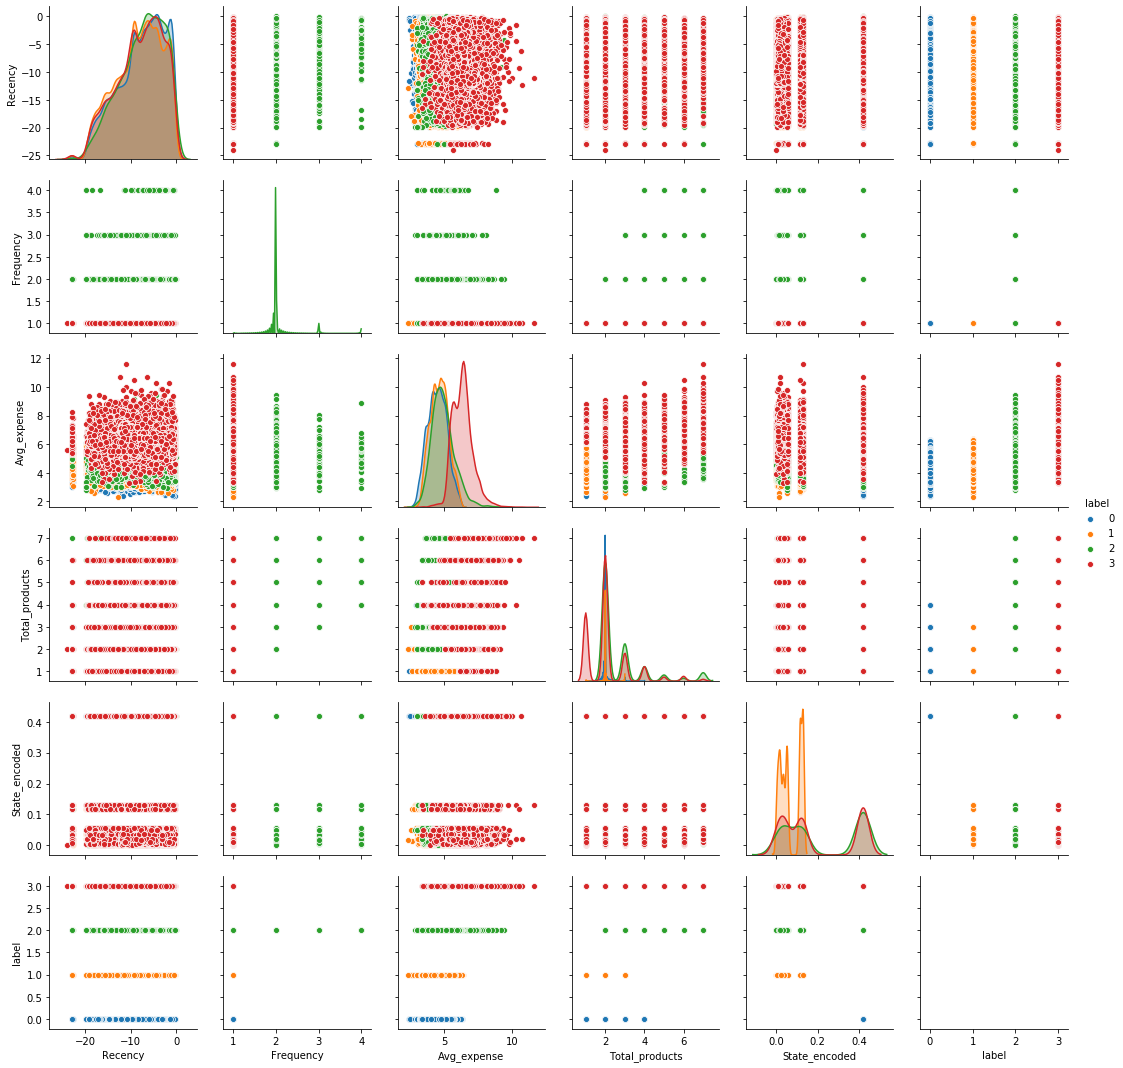

In [50]:
# Matrix of scatterplot of all features
sns.pairplot(data_to_scale, hue='label', diag_kind="auto")
plt.show()

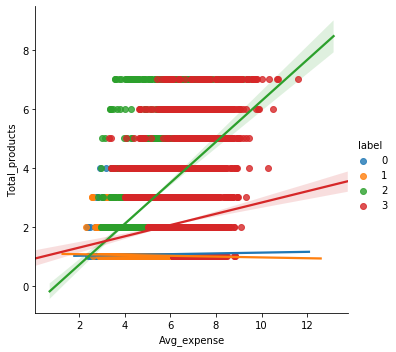

In [57]:
sns.lmplot(x='Avg_expense',y='Total_products',data= data_to_scale,
               hue='label')
plt.show()

In [72]:
# # Insert the label column in the original dataset
# if "label" in data.columns:
#     data.drop("label",axis=1,inplace=True)
# if "Date_order" in data.columns:
#     data.drop("Date_order",axis=1,inplace=True)
# data.insert(6,"label",kmeans_label)
# data2view = pd.merge(data_SG,data, on='customer_unique_id', how='outer')
# data2view.head(3)

In [ ]:
# # Inverse transformation of payment features
# data.Avg_expense = np.exp(data.Avg_expense)-1

### Split data in periods for analysis 

After running the code above for the complete dataset, it is possible to run only this section, chosing the period of time for divide the complete dataset in periods of 3, 4, 6, or 8 months.

In [115]:
# Original data set
data = data_SG[['customer_id','customer_unique_id','customer_state',
               'order_purchase_timestamp','payment_value',
               'Date_order','Month_order']]

In [116]:
# Selection of period
frequency = '182D' # Every 6 months
# 91D : 3 months, 121D : 4 months, 182D : 6 months, 243D : 8 months
date_ranges = pd.date_range(start = min(data.Date_order),
              end = max(data.Date_order),
              freq=frequency).to_period('D').astype('str').tolist()
date_ranges

['2016-09-04', '2017-03-05', '2017-09-03', '2018-03-04', '2018-09-02']

PERIOD  0 
Data shape:  (6410, 7) 

Transactions during period:
min   2016-10-03 09:44:50
max   2017-03-31 23:54:45
Name: order_purchase_timestamp, dtype: datetime64[ns] 

SELECTION OF NUMBER OF CLUSTERS by k-means
For n_clusters = 3 , The average silhouette_score is : 36.6 %
For n_clusters = 4 , The average silhouette_score is : 41.7 %
For n_clusters = 5 , The average silhouette_score is : 43.9 %
For n_clusters = 6 , The average silhouette_score is : 41.2 %
For n_clusters = 7 , The average silhouette_score is : 35.6 %
For n_clusters = 8 , The average silhouette_score is : 36.2 %
For n_clusters = 9 , The average silhouette_score is : 33.1 %
Taking into account the silhouette score for three or more clusters,
the ideal number of clusters for this project is:  5
For n_clusters = 5 , The average silhouette_score is : 43.9 %
In cluster 0 :  1636  customers
In cluster 1 :  504  customers
In cluster 2 :  91  customers
In cluster 3 :  2686  customers
In cluster 4 :  281  customers
k-means clu

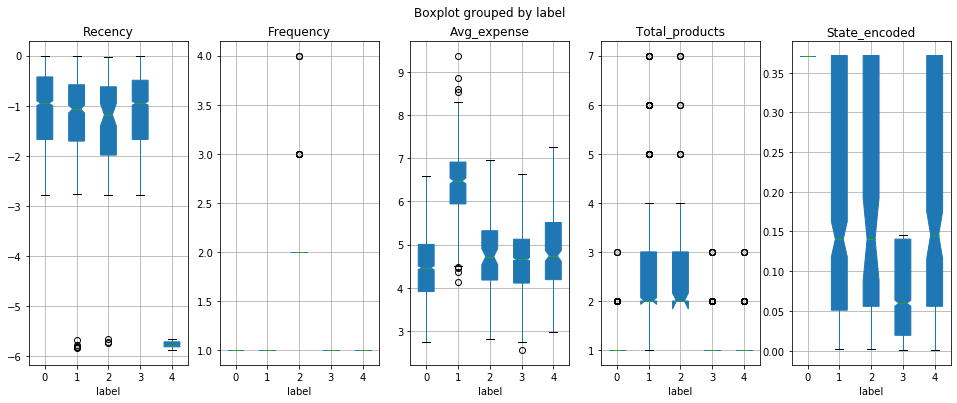

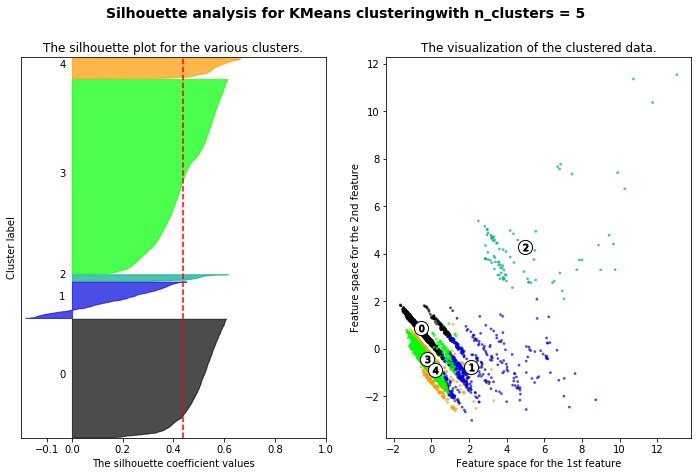

PERIOD  1 
Data shape:  (25398, 7) 

Transactions during period:
min   2017-04-01 00:54:10
max   2017-09-30 23:59:15
Name: order_purchase_timestamp, dtype: datetime64[ns] 

SELECTION OF NUMBER OF CLUSTERS by k-means
For n_clusters = 3 , The average silhouette_score is : 34.4 %
For n_clusters = 4 , The average silhouette_score is : 35.8 %
For n_clusters = 5 , The average silhouette_score is : 35.0 %
For n_clusters = 6 , The average silhouette_score is : 36.3 %
For n_clusters = 7 , The average silhouette_score is : 36.6 %
For n_clusters = 8 , The average silhouette_score is : 36.7 %
For n_clusters = 9 , The average silhouette_score is : 34.5 %
Taking into account the silhouette score for three or more clusters,
the ideal number of clusters for this project is:  8
For n_clusters = 8 , The average silhouette_score is : 36.7 %
In cluster 0 :  5466  customers
In cluster 1 :  2866  customers
In cluster 2 :  1449  customers
In cluster 3 :  3442  customers
In cluster 4 :  532  customers
In clus

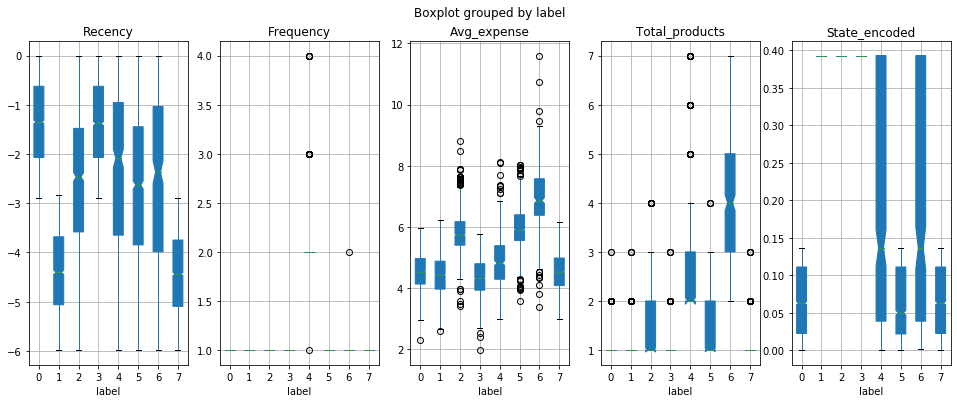

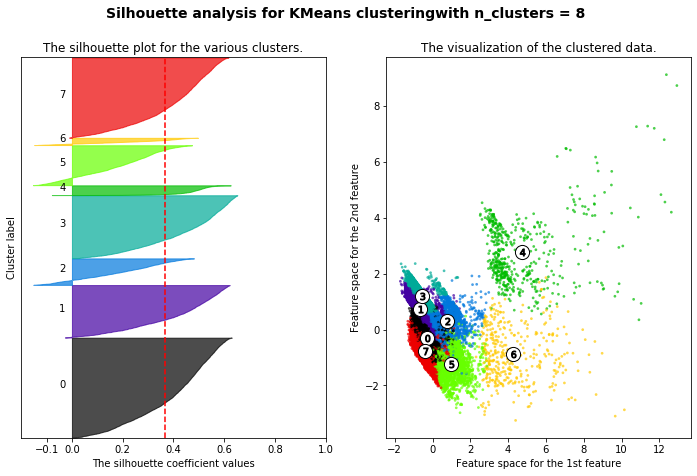

PERIOD  2 
Data shape:  (45065, 7) 

Transactions during period:
min   2017-10-01 00:03:33
max   2018-03-31 23:54:10
Name: order_purchase_timestamp, dtype: datetime64[ns] 

SELECTION OF NUMBER OF CLUSTERS by k-means
For n_clusters = 3 , The average silhouette_score is : 34.4 %
For n_clusters = 4 , The average silhouette_score is : 36.3 %
For n_clusters = 5 , The average silhouette_score is : 35.6 %
For n_clusters = 6 , The average silhouette_score is : 37.6 %
For n_clusters = 7 , The average silhouette_score is : 37.9 %
For n_clusters = 8 , The average silhouette_score is : 38.5 %
For n_clusters = 9 , The average silhouette_score is : 36.0 %
Taking into account the silhouette score for three or more clusters,
the ideal number of clusters for this project is:  8
For n_clusters = 8 , The average silhouette_score is : 38.5 %
In cluster 0 :  8253  customers
In cluster 1 :  2345  customers
In cluster 2 :  6552  customers
In cluster 3 :  9378  customers
In cluster 4 :  813  customers
In clus

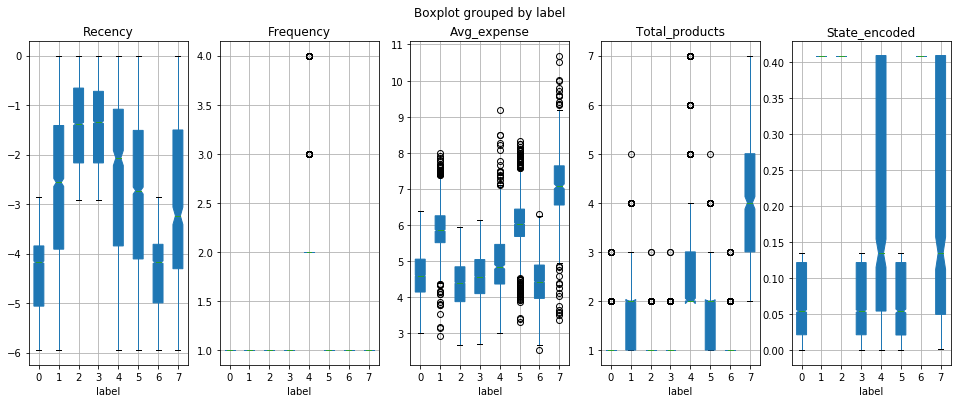

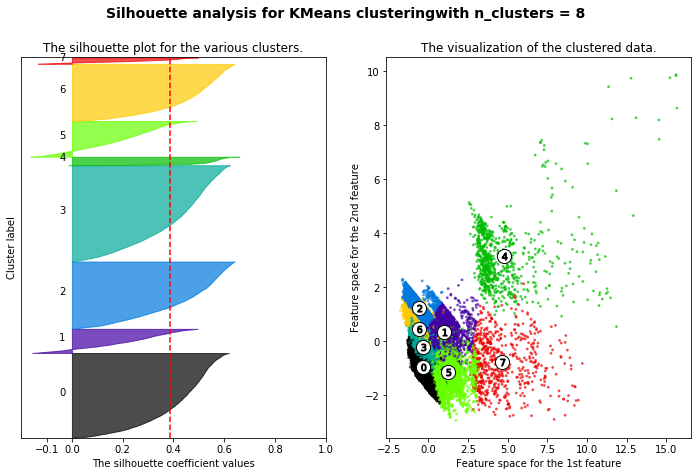

PERIOD  3 
Data shape:  (38087, 7) 

Transactions during period:
min   2018-04-01 00:11:32
max   2018-09-03 09:06:57
Name: order_purchase_timestamp, dtype: datetime64[ns] 

SELECTION OF NUMBER OF CLUSTERS by k-means
For n_clusters = 3 , The average silhouette_score is : 35.4 %
For n_clusters = 4 , The average silhouette_score is : 37.5 %
For n_clusters = 5 , The average silhouette_score is : 33.8 %
For n_clusters = 6 , The average silhouette_score is : 40.0 %
For n_clusters = 7 , The average silhouette_score is : 40.7 %
For n_clusters = 8 , The average silhouette_score is : 41.7 %
For n_clusters = 9 , The average silhouette_score is : 38.7 %
Taking into account the silhouette score for three or more clusters,
the ideal number of clusters for this project is:  8
For n_clusters = 8 , The average silhouette_score is : 41.7 %
In cluster 0 :  2522  customers
In cluster 1 :  6051  customers
In cluster 2 :  7016  customers
In cluster 3 :  2102  customers
In cluster 4 :  473  customers
In clus

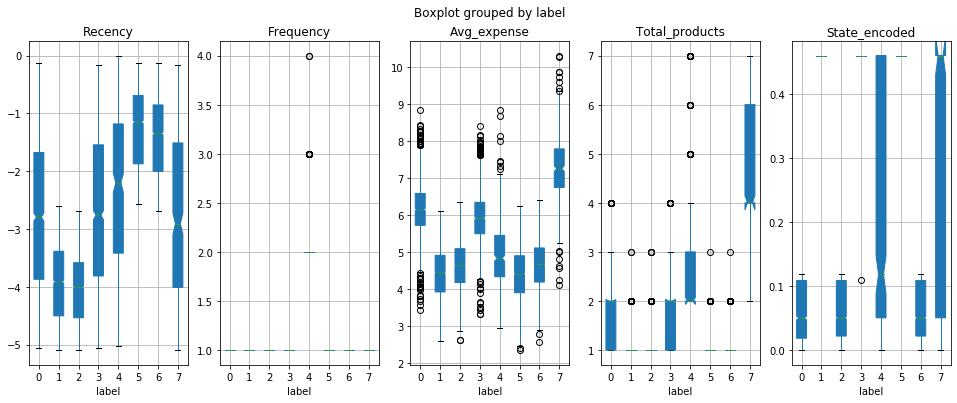

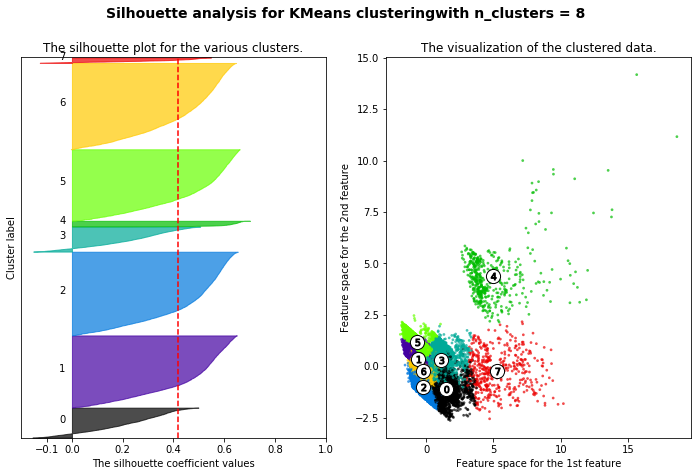

In [117]:
# Feature Enginnering, Preprocessing and Non-supervised clustering models 
# for every period.

for period in range(len(date_ranges)-1):
    data_period_ini = data[data.Month_order >= date_ranges[period]]
    data_period = data_period_ini[data_period_ini.Month_order < \
                                  date_ranges[period+1]]
    print("PERIOD ",period,"\nData shape: ",data_period.shape,"\n")

    # Date of transactions
    print("Transactions during period:")
    print(data_period.order_purchase_timestamp.agg(['min', 'max']),'\n')

    # Product categories features
    data_period = total_products(data_period)
    
    # Payment features
    data_period = recency_customer(data_period)
    data_period = frequency_customer(data_period)
    data_period = average_expense(data_period)

    # Demographie features
    data_period = state_encod(data_period)

    # Selecting columns to use in clustering
    data_period = data_period[['customer_unique_id','Recency','Frequency',
                'Avg_expense','Total_products','State_encoded','Date_order']]

    # Drop duplicates
    data_period = data_period.drop_duplicates(subset=['customer_unique_id'],\
                                              keep='last')

    # Scaling
    ids = data_period.customer_unique_id
    data_to_scale = data_period.drop(['customer_unique_id','Date_order'],axis=1)
    X = preprocessing.StandardScaler().fit_transform(data_to_scale)

    # PCA
    features = data_to_scale.columns
    X_pca, pca = PCA_features(X, n_comp)

    # Selection of number of clusters by k-means
    print("SELECTION OF NUMBER OF CLUSTERS by k-means")
    range_n_clusters = [3,4,5,6,7,8,9]
    kmeans_silhouette = []
    kmeans_labels = []
    for n_clusters in range_n_clusters:   
        kmeans_label,silhouette_avg,clusterer = cluster_kmeans(X_pca,n_clusters)
        kmeans_silhouette.append(silhouette_avg)
    max_sil_index = kmeans_silhouette.index(max(kmeans_silhouette))
    n_clusters = range_n_clusters[max_sil_index]
    print("Taking into account the silhouette score for three or more clusters" 
          "\nthe ideal number of clusters for this project is: ", n_clusters)
    
    # Unsupervised k-means clustering 
    kmeans_label,silhouette_avg,clusterer = cluster_kmeans(X_pca, n_clusters)
  
    # Create the label column 
    if "label" in data_to_scale.columns:
        data_to_scale.drop("label", axis=1, inplace=True)
    data_to_scale.insert(5, "label", kmeans_label, True)
    
    # Count the number of customers for each cluster
    median_kmeans_cluster = []
    for n in range(n_clusters):    
        actual_cluster = data_to_scale[data_to_scale.label == n]
        median_kmeans_cluster.append(np.median(actual_cluster,0))
        print("In cluster",n,": ",len(actual_cluster)," customers")
    median_kmeans_cluster = pd.DataFrame(median_kmeans_cluster,\
                columns=data_to_scale.columns,index=range(n_clusters))

    # Features traitement for better visualisation
    if np.median(median_kmeans_cluster.Recency) < 0:
        median_kmeans_cluster.Recency = -median_kmeans_cluster.Recency
    if np.median(median_kmeans_cluster.State_encoded) < 1:
        median_kmeans_cluster.State_encoded = np.array(\
                                    median_kmeans_cluster.State_encoded)*10
    # Polar graph of targets for each cluster 
    categories = data_to_scale.columns[:-1]
    print("k-means clustering")
    plot_scatterpolar(median_kmeans_cluster.loc[:,categories],categories)
        
    # Boxplot of features by label
    fig, axes = plt.subplots(nrows= 1,ncols=5, figsize=(16, 6))
    data_to_scale.boxplot(column=['Recency','Frequency','Avg_expense',
            'Total_products','State_encoded'], 
             by='label', notch=True, patch_artist=True,
             vert=True, ax=axes)
    plt.show()
    
    # Clustering
    plot_sample_silhouette(X_pca, n_clusters, kmeans_label,\
                           silhouette_avg, clusterer)

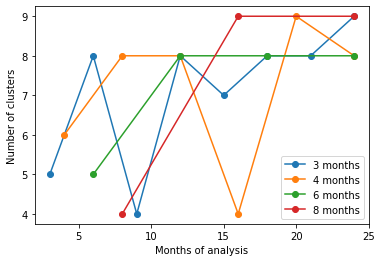

In [97]:
# Resume of test indicating the best number of clusters calculated
# for periods of 3, 4, 6, and 8 months
month = [[3,6,9,12,15,18,21,24],[4,8,12,16,20,24],[6,12,18,24],[8,16,24]]
nb_cl = [[5,8,4,8,7,8,8,9],[6,8,8,4,9,8],[5,8,8,8],[4,9,9]]
for i in range(4):
    plt.plot(month[i],nb_cl[i],marker='o')
plt.legend(['3 months','4 months','6 months','8 months'])
plt.xlabel('Months of analysis')
plt.ylabel('Number of clusters')
plt.show()

The clustering should be actualised every semester, as is seen in green line, where the calcul of number of clusters is constant in 8 clusters. Even if red line (periods of 8 months) is also stable, looking into the clusters, there are more variability, like the apparition of clusters with less than 100 individus.